In [ ]:
import pandas as pd
from pathlib import Path
import sys
# sys.path.append(str(Path(__file__).parent.parent))
sys.path.append("..")
from utils.load import load_embeddings_dataset, clean_metadata_column
import pyarrow.parquet as pq
import numpy as np
from graphviz import Graph
import igraph
igraph.config["plotting.backend"] = "matplotlib"
from igraph import Graph, plot
from utils.graph_visualization import visualize_graph
from utils.graph_clustering import spectral_clustering, to_knn_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils.internal_validation_metrics import manual_silhouette_score
# from utils.external_validation import plot_merged_attribute_heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import ast
import numpy as np
from scipy.stats import chi2


Loading the dataset

In [26]:
embeddings_df = load_embeddings_dataset("../data/videogame_embeddings/embedding_dataset.parquet")

Temporary functions for dimensionality reduction 

In [40]:
def reduce_dim(X):
    pca = PCA().fit(X)

    # cumulative explained variance
    cumvar = np.cumsum(pca.explained_variance_ratio_)

    # nr of components for at least 90% explained variance
    # k = np.searchsorted(cumvar, 0.90) + 1
    k = 30

    # print("Components needed for 90% variance:", k)

    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)

    return X_pca


def mahalanobis_mask(X_pca, alpha=0.001):
    """
    Remove multivariate outliers using Mahalanobis distance thresholding.
    alpha: significance level (0.001 ~ 3.3std equivalent)
    """
    cov = np.cov(X_pca, rowvar=False)
    cov_inv = np.linalg.inv(cov)
    mean = X_pca.mean(axis=0)

    d2 = np.array([
        (x - mean).T @ cov_inv @ (x - mean)
        for x in X_pca
    ])

    threshold = chi2.ppf(1 - alpha, df=X_pca.shape[1])
    mask = d2 < threshold

    return mask, d2, threshold



Get k closest neighbors for sparsifying the graph.

In [53]:
embedding_cols = ['ast', 'wavlm', 'clap']  
from sklearn.metrics.pairwise import cosine_similarity

game_names = embeddings_df['name'].values

# Dictionary for similarity matrices
similarity_matrices = {}
maskings = {}

for col in embedding_cols:
    print(f"Computing cosine similarity for {col}...")
    
    embeddings = np.stack(embeddings_df[col].values) 

    mask, _, _ = mahalanobis_mask(reduce_dim(embeddings), alpha=0.001)

    maskings[col] = mask

    X_pca = reduce_dim(embeddings)

    embeddings = X_pca[mask]
    
    sim_matrix = cosine_similarity(embeddings)
   
    np.fill_diagonal(sim_matrix, 0)
    
    similarity_matrices[col] = sim_matrix.astype(np.float32)




Computing cosine similarity for ast...
Computing cosine similarity for wavlm...
Computing cosine similarity for clap...


In [43]:
similarity_matrices

{'ast': array([[ 0.        ,  0.5036843 ,  0.67750823, ...,  0.16268721,
          0.33216697,  0.00225616],
        [ 0.5036843 ,  0.        ,  0.46971434, ...,  0.00687712,
          0.25203505,  0.05472557],
        [ 0.67750823,  0.46971434,  0.        , ...,  0.16747762,
          0.337124  , -0.02031855],
        ...,
        [ 0.16268721,  0.00687712,  0.16747762, ...,  0.        ,
          0.31234062,  0.0164093 ],
        [ 0.33216697,  0.25203505,  0.337124  , ...,  0.31234062,
          0.        ,  0.6783347 ],
        [ 0.00225616,  0.05472557, -0.02031855, ...,  0.0164093 ,
          0.6783347 ,  0.        ]], dtype=float32),
 'wavlm': array([[ 0.        , -0.25533348,  0.73951894, ..., -0.531893  ,
          0.29606086, -0.5380725 ],
        [-0.25533348,  0.        , -0.12352942, ...,  0.06009278,
          0.23969255,  0.41514102],
        [ 0.73951894, -0.12352942,  0.        , ..., -0.6392035 ,
          0.4982917 , -0.2784376 ],
        ...,
        [-0.531893  ,  

Distribution of cosine similarity matrix for ast

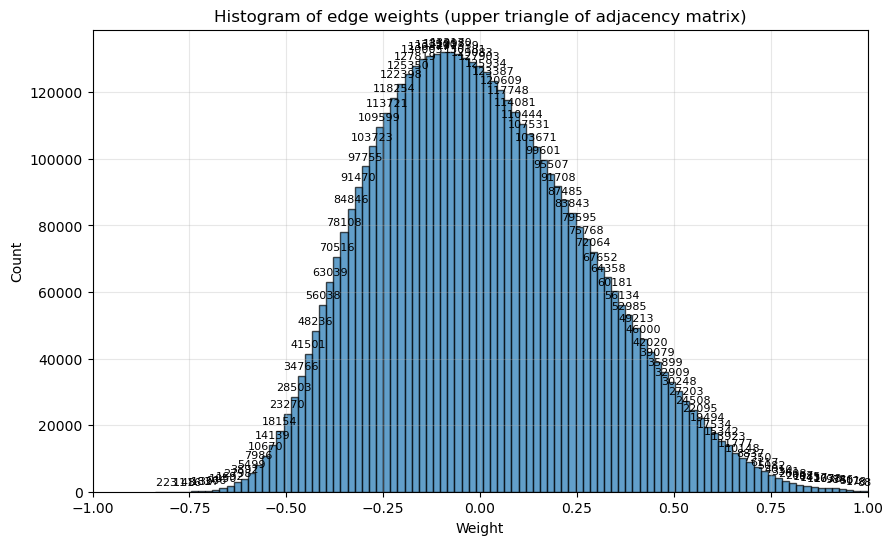

In [58]:
A = similarity_matrices["clap"]

upper_triangle_values = A[np.triu_indices_from(A, k=1)]

# Now compute the histogram
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(upper_triangle_values, 
                           bins=100, 
                           edgecolor='black', 
                           alpha=0.7, 
                           density=False)  # use density=True if you want probability density

plt.title('Histogram of edge weights (upper triangle of adjacency matrix)')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.xlim(-1,1)

# Optional: show the actual counts on top of bars
for c, b in zip(counts, bins):
    if c > 0:
        plt.text(b + (bins[1]-bins[0])/2, c + max(counts)*0.01, 
                 f'{int(c)}', ha='center', va='bottom', fontsize=8)

plt.show()

In [ ]:
num_neighbors = 15

for k in list(similarity_matrices.keys()):
    similarity_matrices[k] = to_knn_similarity(similarity_matrices[k], num_neighbors)

check Sillouette scores for different clustering groups.

In [ ]:
# Collect silhouette scores for plotting
sil_scores_collection = {}

# From k=2 to k=14, test silhouette scores
min_k = 2
max_k=15
k_ranges = [r for r in range(min_k, max_k)]

for col in embedding_cols:
    print(f"Silhouette scores for {col}...")
    s_matrix = similarity_matrices[col]

    for k_test in k_ranges:
        if col not in sil_scores_collection:
             [col] = []
        
        labels, X_norm = spectral_clustering(s_matrix, k=k_test)
        sil_score = manual_silhouette_score(X_norm, labels)

        print(f"k = {k_test}: {sil_score:.4f}")

        sil_scores_collection[col].append(sil_score)

Silhouette scores for ast...
k = 2: 0.6713
k = 3: 0.5689
k = 4: 0.5237
k = 5: 0.4871
k = 6: 0.4679
k = 7: 0.4696
k = 8: 0.4026
k = 9: 0.3806
k = 10: 0.3863
k = 11: 0.3811
k = 12: 0.3555
k = 13: 0.3450
k = 14: 0.3520
Silhouette scores for wavlm...
k = 2: 0.7376
k = 3: 0.6308
k = 4: 0.4740
k = 5: 0.4387
k = 6: 0.3755
k = 7: 0.3660
k = 8: 0.3996
k = 9: 0.4126
k = 10: 0.3440
k = 11: 0.3195
k = 12: 0.3030
k = 13: 0.3096
k = 14: 0.3103
Silhouette scores for clap...
k = 2: 0.6603
k = 3: 0.6705
k = 4: 0.6330
k = 5: 0.5340
k = 6: 0.5165
k = 7: 0.4789
k = 8: 0.4976
k = 9: 0.4075
k = 10: 0.3876
k = 11: 0.3865
k = 12: 0.3840
k = 13: 0.3669
k = 14: 0.3906


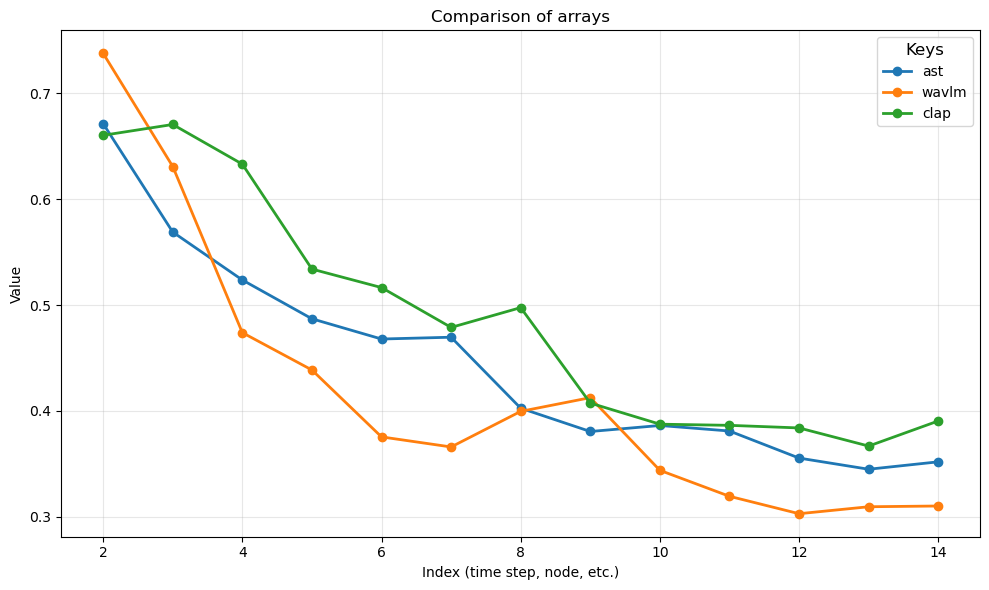

In [47]:
plt.figure(figsize=(10, 6))

for key, array in sil_scores_collection.items():
    plt.plot(k_ranges, array,  label=key, marker='o', linewidth=2)

# Beautiful legend and labels
plt.legend(title="Keys", fontsize=10, title_fontsize=12, loc='best')
plt.xlabel("Index (time step, node, etc.)")
plt.ylabel("Value")
plt.title("Comparison of arrays")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

We decide k=8 clusters 

In [48]:
num_clusters = 8
embedding_labels = {}

for col in embedding_cols:
    s_matrix = similarity_matrices[col]
    labels, X_norm = spectral_clustering(s_matrix, k=8)
    embedding_labels[col] = labels

100%|██████████| 2000/2000 [00:59<00:00, 33.49it/s]


BarnesHut Approximation  took  33.20  seconds
Repulsion forces  took  23.87  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  0.55  seconds
AdjustSpeedAndApplyForces step  took  0.98  seconds


100%|██████████| 2000/2000 [00:48<00:00, 40.97it/s]


BarnesHut Approximation  took  19.51  seconds
Repulsion forces  took  26.49  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.60  seconds
AdjustSpeedAndApplyForces step  took  0.95  seconds


100%|██████████| 2000/2000 [00:47<00:00, 41.81it/s]


BarnesHut Approximation  took  19.71  seconds
Repulsion forces  took  25.51  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  0.55  seconds
AdjustSpeedAndApplyForces step  took  0.95  seconds


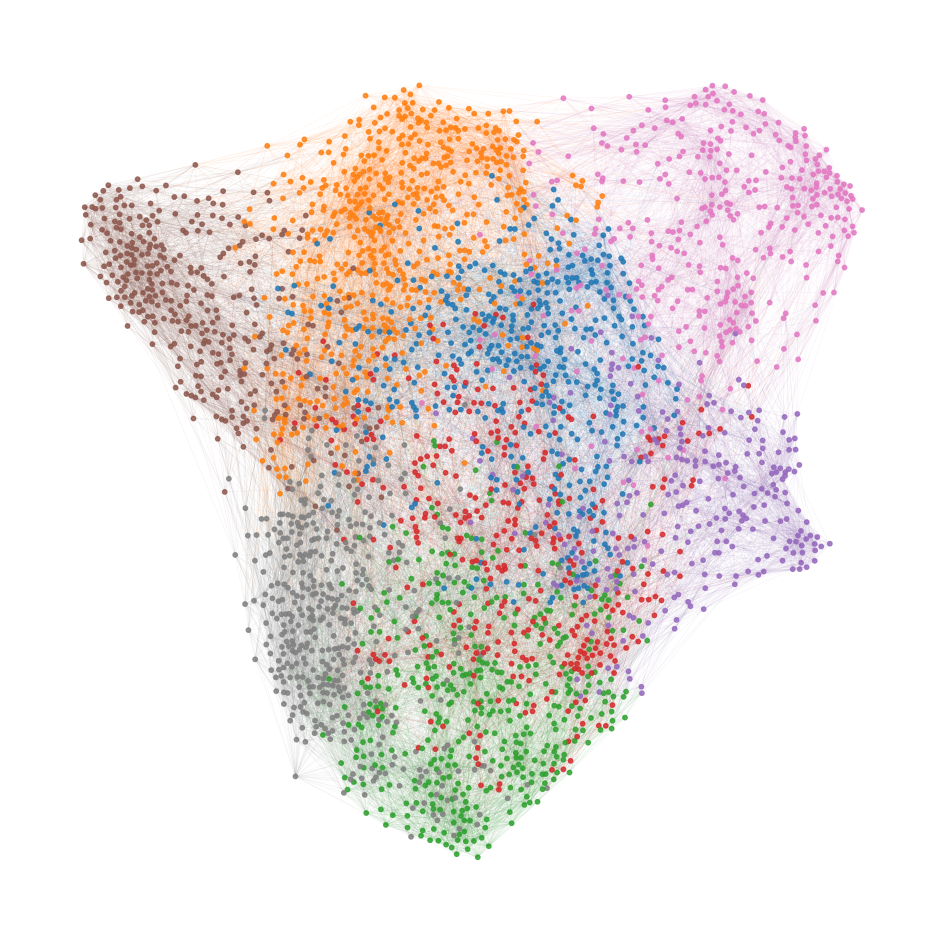

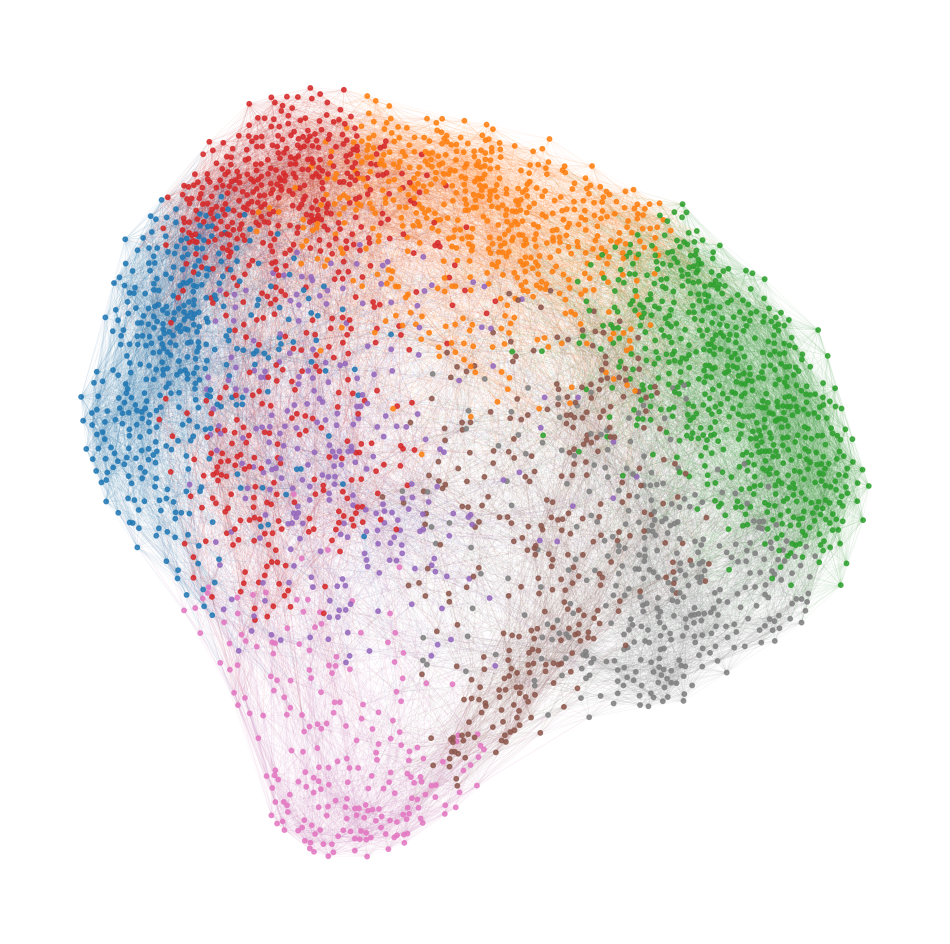

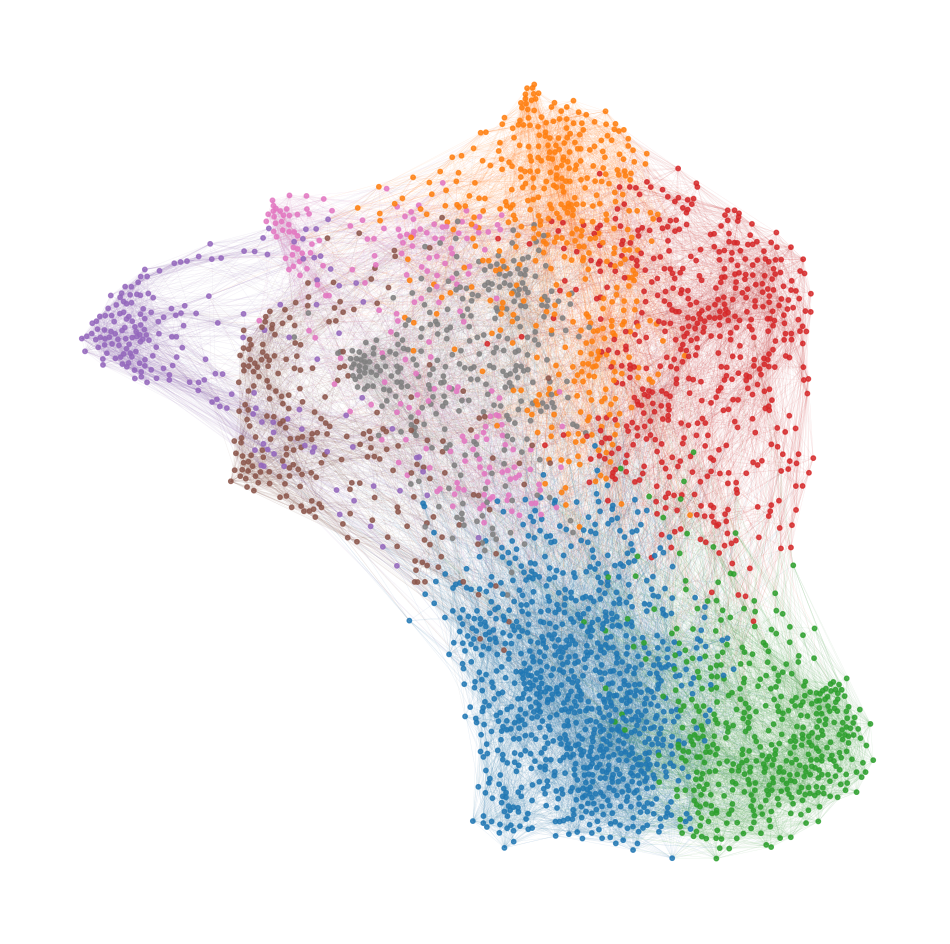

In [50]:
for col in embedding_cols:
    s_matrix = similarity_matrices[col]
    label = embedding_labels[col]
    filename = col

    visualize_graph(s_matrix, label, filename)

Validation

In [ ]:
lbls = embedding_labels['ast']

In [ ]:
df_metadata = clean_metadata_column(embeddings_df)

In [ ]:
embeddings_df

filename  \
0                           Luke_s_Theme_(Arranged).wav   
1                                 Death_Star_Attack.wav   
2                             Battle_for_Storm_Hill.wav   
3                                    Aerie_Fortress.wav   
4                                         Stage_2-2.wav   
...                                                 ...   
3327        The_King_of_Fighters__94_-_Introduction.wav   
3328  Psycho_Soldier_(KOF_Version)_-_The_Psycho_Sold...   
3329                              Esaka_-_Hero_Team.wav   
3330                   Slum_No._5_-_USA_Sports_Team.wav   
3331                          Ne!_-_The_Ladies_Team.wav   

                                                    ast  \
0     [1.374433, 1.0695944, 0.04797495, -0.42208233,...   
1     [1.2433861, -0.14838827, -0.33959186, 0.145193...   
2     [1.1444644, 0.13062434, -0.4718857, 0.09288005...   
3     [0.9122599, 0.2314296, -0.008622774, 0.2431591...   
4     [0.9520262, 0.1271173, 0.061484247, -0.1729279...   
...                                                 ...   
3327  [1.0912422, -0.0129516935, 0.30982116, 0.55649...   
3328  [0.97219384, 0.17524515, 0.6814193, 0.11768077...   
3329  [0.8066606, -0.06493412, 0.141068, 0.20738474,...   
3330  [0.7795071, 0.07473013, 0.46593213, -0.1703361...   
3331  [1.022288, -0.124896936, -0.1775347, -0.149211...   

                                                  wavlm  \
0     [-0.00248229, 0.05962407, -0.0011553991, 0.103...   
1     [-0.008416168, 0.018923571, -0.070149176, 0.05...   
2     [-0.008840599, -0.006281961, -0.058815807, 0.0...   
3     [0.070501156, 6.1879415e-05, -0.021063795, 0.0...   
4     [0.031276666, -0.008869544, -0.04219547, 0.026...   
...                                                 ...   
3327  [0.064533845, -0.015578991, -0.08771855, 0.003...   
3328  [0.05489374, 0.016396465, -0.044301257, 0.0222...   
3329  [0.0791561, 0.010458036, -0.0013798836, 0.0145...   
3330  [-0.009928201, 0.0013620572, -0.05092889, 0.05...   
3331  [0.013747389, 0.03157222, -0.030342733, 0.0411...   

                                                   clap      id  \
0     [0.0063681714, -0.37322238, -0.30396485, -0.83...    4181   
1     [0.3747486, -0.0049350746, -0.8977523, -0.8723...    4181   
2     [0.57902086, 0.007904012, -0.15739492, -0.1549...    1097   
3     [1.045783, -0.017928796, 0.08965086, -1.298964...    1097   
4     [0.10054495, -1.270201, 0.6900546, -0.41986156...  341259   
...                                                 ...     ...   
3327  [0.93032384, 0.4066865, 0.427979, -0.6726512, ...   15426   
3328  [0.9854675, -1.0771613, 0.3837564, 1.342298, 2...   15426   
3329  [1.5594902, -0.029260391, -0.157613, -0.501181...   15426   
3330  [0.561328, -0.8572535, 0.47886965, -0.65833634...   15426   
3331  [0.03215663, -0.3288156, 0.11041445, -0.872815...   15426   

                                             name rating  \
0     Star Wars: Rogue Squadron II - Rogue Leader   85.4   
1     Star Wars: Rogue Squadron II - Rogue Leader   85.4   
2                         Donkey Kong Jungle Beat   67.7   
3                         Donkey Kong Jungle Beat   67.7   
4                                   Viewtiful Joe      0   
...                                           ...    ...   
3327                     The King of Fighters '94   67.7   
3328                     The King of Fighters '94   67.7   
3329                     The King of Fighters '94   67.7   
3330                     The King of Fighters '94   67.7   
3331                     The King of Fighters '94   67.7   

                             themes  \
0     ["Action", "Science fiction"]   
1     ["Action", "Science fiction"]   
2                        ["Action"]   
3                        ["Action"]   
4                        ["Action"]   
...                             ...   
3327                     ["Action"]   
3328                     ["Action"]   
3329                     ["Action"]   
3330

In [ ]:
cluster_corpus = {}
emb_type_corpus = {}

for emb_type in list(embedding_labels.keys()):

    if emb_type not in emb_type_corpus:
            emb_type_corpus[emb_type] = {}
    
    lbls = embedding_labels[emb_type]
    for i in range(len(lbls)):
        cluster = lbls[i]
        
        if cluster not in emb_type_corpus[emb_type]:
            emb_type_corpus[emb_type][cluster] = []
        emb_type_corpus[emb_type][cluster].append(df_metadata["metadata"].iloc[i])

In [ ]:
emb_type_corpus['ast'].keys()

dict_keys([np.int32(2), np.int32(3), np.int32(1), np.int32(4), np.int32(5), np.int32(0)])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


clusters = list(cluster_corpus.keys())

cluster_texts = [cluster_corpus[c][0] for c in clusters]
clusters = [int(c) for c in clusters]



# cluster_texts = list of K strings (each string = all texts in that cluster joined)
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',      # optional but recommended
    min_df=1,                  # appears in at least 1 cluster
    max_df=1.0,                # no upper limit needed with only K docs
    token_pattern=r'(?u)\b\w+\b'  # or use ngrams
)

tfidf_matrix = vectorizer.fit_transform(cluster_texts)  # Shape: (K, vocab_size)
feature_names = vectorizer.get_feature_names_out()

In [ ]:
feature_names

array(['5', '616', '7', 'action', 'activision', 'anime', 'awards',
       'bandai', 'based', 'block', 'bread', 'capcom', 'cheat', 'chest',
       'civil', 'clock', 'clover', 'code', 'combat', 'comedy',
       'commentary', 'critics', 'cycle', 'day', 'developer', 'empire',
       'escort', 'factor', 'fantasy', 'fast', 'fiction', 'flight',
       'galactic', 'game', 'gamecube', 'games', 'gateway', 'greatest',
       'hits', 'holdings', 'horror', 'ice', 'ii', 'joe', 'jrpg', 'killer',
       'launch', 'leader', 'leveling', 'licensed', 'lucasarts', 'magic',
       'manga', 'mission', 'movie', 'namco', 'night', 'nintendo', 'pilot',
       'poop', 'potion', 'puzzle', 'real', 'refrigerators', 'robots',
       'rogue', 'science', 'simulation', 'snow', 'space', 'spaceship',
       'squadron', 'stage', 'star', 'studio', 'symphonia', 'syndrome',
       'tales', 'time', 'titles', 'traveling', 'treasure', 'trilogy',
       'viewtiful', 'war', 'warping', 'wars', 'wing', 'women', 'x'],
      dtype=obj

In [ ]:
K = len(cluster_texts)
for cluster_id in range(K):
    row = tfidf_matrix[cluster_id].toarray().flatten()
    top_n_indices = row.argsort()[-5:][::-1]  # top 20 terms
    print(f"\nCluster {cluster_id} most distinctive words:")
    for idx in top_n_indices:
        print(f"  {feature_names[idx]:15s} → {row[idx]:.4f}")


Cluster 0 most distinctive words:
  game            → 0.3489
  space           → 0.2326
  star            → 0.2326
  wars            → 0.2326
  galactic        → 0.2326

Cluster 1 most distinctive words:
  game            → 0.3489
  space           → 0.2326
  star            → 0.2326
  wars            → 0.2326
  galactic        → 0.2326

Cluster 2 most distinctive words:
  capcom          → 0.4592
  joe             → 0.4592
  viewtiful       → 0.4592
  clover          → 0.4592
  studio          → 0.3179

Cluster 3 most distinctive words:
  616             → 0.3780
  7               → 0.3780
  killer          → 0.3780
  horror          → 0.3780
  comedy          → 0.3780

Cluster 4 most distinctive words:
  namco           → 0.4827
  tales           → 0.3218
  jrpg            → 0.1609
  ice             → 0.1609
  leveling        → 0.1609

Cluster 5 most distinctive words:
  namco           → 0.4827
  tales           → 0.3218
  jrpg            → 0.1609
  ice             → 0.1609
  level

In [51]:
def plot_merged_attribute_heatmap(df, labels, top_n=5):
    """
    Merges 'themes', 'keywords', 'involved_companies', and 'game' into a single 
    analysis pool and plots distinctive terms per cluster.
    """
    local_df = df.copy()
    local_df['cluster'] = labels
    
    # Define the columns we want to merge
    # Ensure these exist in your dataframe; remove any that don't
    target_cols = ["themes", "keywords", "involved_companies", "game"]
    valid_cols = [c for c in target_cols if c in local_df.columns]
    
    # --- STEP 1: NORMALIZE EVERYTHING TO LISTS ---
    for col in valid_cols:
        # Fill NaNs with empty list representation
        local_df[col] = local_df[col].fillna("[]")
        
        def standardize_to_list(val):
            try:
                # Case A: It's already a list -> Keep it
                if isinstance(val, list):
                    return val
                
                # Case B: It's a string
                if isinstance(val, str):
                    val = val.strip()
                    # Case B1: Stringified list "['Action', 'FPS']" -> Convert to list
                    if val.startswith('[') and val.endswith(']'):
                        return ast.literal_eval(val)
                    # Case B2: Regular string "Halo 3" -> Wrap in list ['Halo 3']
                    # Check if empty string
                    if val == "" or val == "[]":
                        return []
                    return [val]
                
                # Case C: Other (numbers, etc) -> Wrap in list
                return [str(val)]
            except:
                return []

        local_df[col] = local_df[col].apply(standardize_to_list)

    # --- STEP 2: MERGE COLUMNS ---
    # Now that all columns are actual lists, we can sum them row-wise
    # This concatenates ['Halo'] + ['Action'] -> ['Halo', 'Action']
    local_df['all_tags'] = local_df[valid_cols].sum(axis=1)

    # --- STEP 3: EXPLODE ---
    exploded_df = local_df.explode('all_tags')
    
    # Clean up: remove short garbage strings or numbers that might have slipped in
    exploded_df['all_tags'] = exploded_df['all_tags'].astype(str)
    exploded_df = exploded_df[exploded_df['all_tags'].str.len() > 2]

    # --- STEP 4: CALCULATE METRICS (LIFT) ---
    global_counts = exploded_df['all_tags'].value_counts(normalize=True)
    unique_clusters = sorted(local_df['cluster'].unique())
    
    lift_grid = np.zeros((len(unique_clusters), top_n))
    word_grid = np.full((len(unique_clusters), top_n), "", dtype=object)
    
    for i, c in enumerate(unique_clusters):
        c_counts = exploded_df[exploded_df['cluster'] == c]['all_tags'].value_counts(normalize=True)
        
        # Calculate Lift
        lift = c_counts / global_counts.reindex(c_counts.index).fillna(1)
        
        top_k = lift.sort_values(ascending=False).head(top_n)
        
        for rank, (word, score) in enumerate(top_k.items()):
            if rank < top_n:
                lift_grid[i, rank] = score
                # Wrap text for heatmap
                clean_word = textwrap.fill(str(word), width=12) 
                word_grid[i, rank] = clean_word

    # --- STEP 5: PLOT ---
    plt.figure(figsize=(14, len(unique_clusters) * 1.4))
    
    ax = sns.heatmap(
        lift_grid, 
        annot=word_grid, 
        fmt="", 
        cmap="Blues", 
        linewidths=1.0,
        linecolor='white',
        yticklabels=[f"Cluster {c+1}" for c in unique_clusters],
        xticklabels=[f"Rank {i+1}" for i in range(top_n)],
        annot_kws={"size": 9, "weight": "bold"},
        cbar_kws={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Lift Score (Distinctiveness)"}
    )
    
    ax.set_title("Most Distinctive Attributes (Themes, Keywords, Games, Companies) by Cluster", fontsize=16, pad=20)
    plt.yticks(rotation=0)
    ax.xaxis.tick_top()
    
    plt.tight_layout()
    plt.show()

For ast

In [56]:
clean_df = embeddings_df[maskings["ast"]]

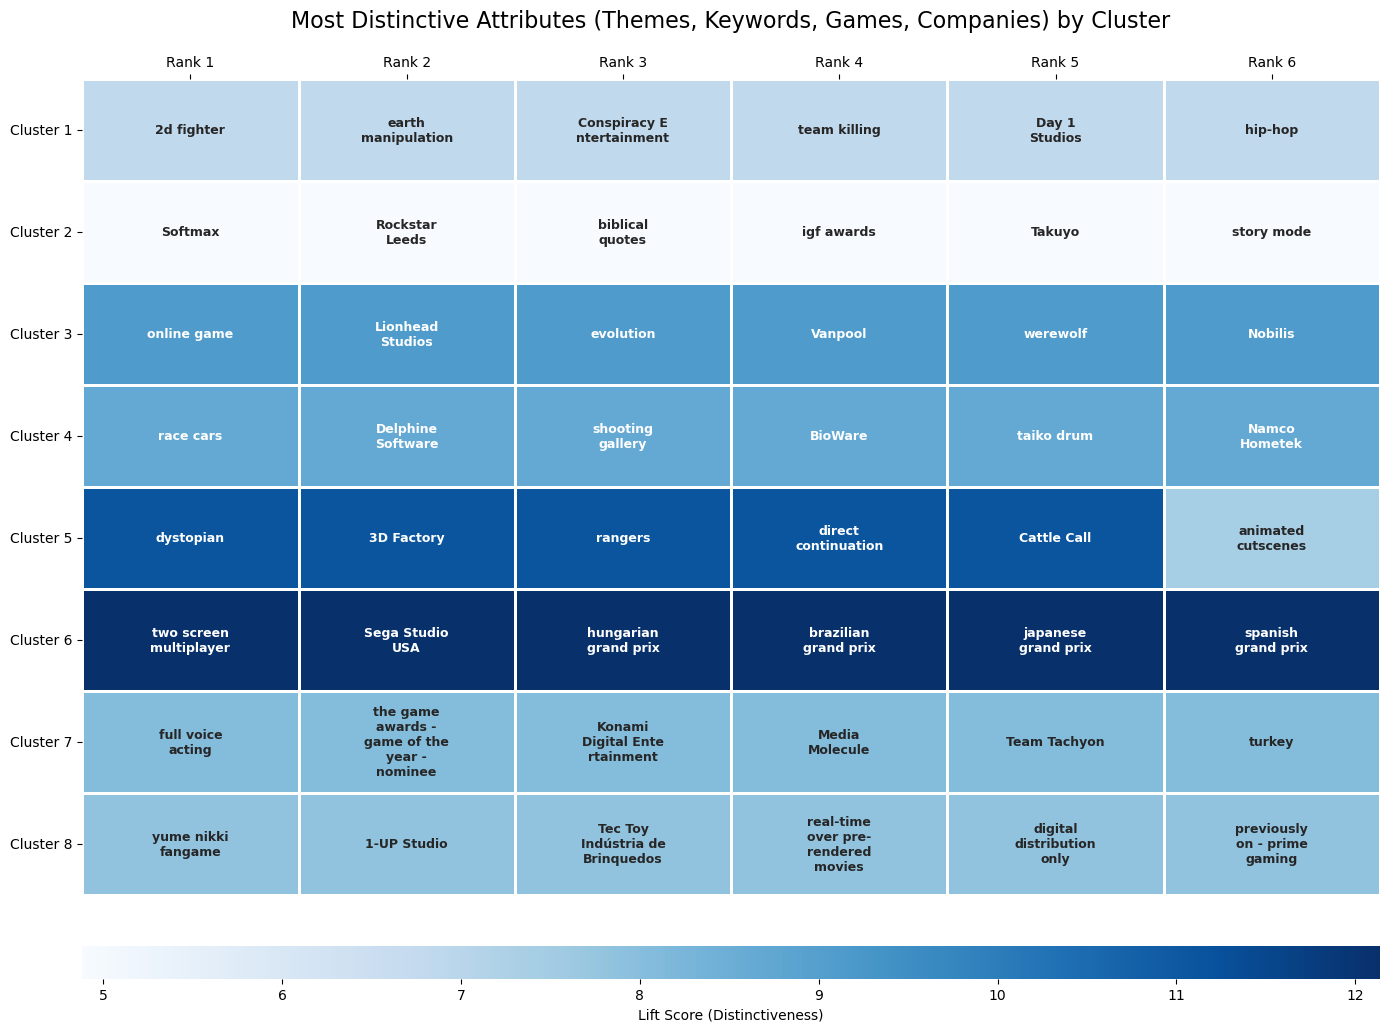

In [57]:
plot_merged_attribute_heatmap(clean_df, embedding_labels["ast"], top_n=6)

## External Validation

In [88]:
import json
from loguru import logger
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer


from typing import Dict, List, Optional, Any, Union

In [76]:
df_metadata = clean_metadata_column(embeddings_df)
ast_df = df_metadata[maskings["ast"]]
ast_df["cluster_label"] = embedding_labels["ast"]

/var/folders/4l/6stdwbh56pvgwz8thwnlgtq80000gn/T/ipykernel_52068/3366386491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ast_df["cluster_label"] = embedding_labels["ast"]


In [78]:
def column_wise_summary(
    df: pd.DataFrame,
    columns: List[str],
    save_path: str,
) -> None:
    """
    For each cluster and each column:
    - Count occurrences of each unique element.
    - Fully supports list-like columns (themes, keywords, companies).
    - Saves a JSON summary of value frequencies.

    Output format:
    {
        "0": {
            "themes": {"Action": 10, "Sci-fi": 4, ...},
            "keywords": {...},
            ...
        },
        "1": { ... },
        ...
    }
    """
    
    clusters = sorted(df["cluster_label"].unique())

    summary: Dict[Any, Dict[str, Dict[str, int]]] = {}

    for c in clusters:
        # Convert cluster label to JSON-serializable type
        c_key = str(int(c)) if isinstance(c, (np.integer, np.floating)) else str(c)
        subset = df[df["cluster_label"] == c]
        cluster_num = len(subset)
        
        summary[c_key] = {
            col: {} for col in columns
        }
        summary[c_key]["cluster_size"] = cluster_num
        
        for col in columns:
            logger.debug(f"Processing cluster {c_key}, column '{col}'…")
            subset = df[df["cluster_label"] == c]

            # Ensure the nested dict for this column exists
            if col not in summary[c_key]:
                summary[c_key][col] = {}

            if subset.empty:
                logger.warning(f"Cluster {c_key} has no entries for column '{col}'.")
                # Keep as empty dict for empty subsets
                continue
            

            # Flatten list values OR handle scalar values
            flat_values = []
            for item in subset[col]:
                if isinstance(item, str):
                    # Try to parse JSON string
                    try:
                        parsed = ast.literal_eval(item)
                        if isinstance(parsed, list):
                            flat_values.extend(parsed)
                        else:
                            flat_values.append(parsed)
                    except (ValueError, SyntaxError):
                        # Not JSON, treat as plain string
                        flat_values.append(item)
                elif isinstance(item, list):
                    flat_values.extend(item)
                else:
                    flat_values.append(item)

            counts = dict(Counter(flat_values))
            # Convert keys and values to JSON-serializable types
            counts = {str(k): int(v) for k, v in counts.items() if isinstance(v, (int, np.integer))}
            # Sort by count (descending)
            counts = dict(sorted(counts.items(), key=lambda x: -x[1]))
            # Store counts under a dedicated key to avoid overwriting
            summary[c_key][col]["counts"] = counts

    with open(save_path, "w") as f:
        json.dump(summary, f, indent=4)

    return None

In [82]:
column_wise_summary(ast_df, ["name", "themes", "keywords", "involved_companies", "first_release_year"], "../results/embedding_general/graph_clustering/gc.json")

2025-12-02 21:58:57.337 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'name'…
2025-12-02 21:58:57.342 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'themes'…
2025-12-02 21:58:57.347 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'keywords'…
2025-12-02 21:58:57.373 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'involved_companies'…
2025-12-02 21:58:57.378 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 0, column 'first_release_year'…
2025-12-02 21:58:57.381 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, column 'name'…
2025-12-02 21:58:57.386 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, column 'themes'…
2025-12-02 21:58:57.391 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, column 'keywords'…
2025-12-02 21:58:57.422 | DEBUG    | __main__:column_wise_summary:40 - Processing cluster 1, col

In [90]:
def tfidf_cluster_summary(
    df: pd.DataFrame,
    save_path: Optional[str] = None,
    k: int = 20,
    ngram_range=(1, 2),
    min_df: int = 1,
    max_df: float = 0.8,
    scoring: str = "distinctiveness",  # "distinctiveness" or "tfidf"
) -> Dict[Union[int, str], List[str]]:
    """
    Compute top-k keywords per cluster from the 'metadata' column.

    Uses a GLOBAL TF-IDF fit and selects terms that are
    distinctive to each cluster via:
        score = mean_tfidf_in_cluster - mean_tfidf_global

    Args:
        df: DataFrame containing 'cluster_label' and 'metadata' (or 'metadata_combined').
        k: Top-k terms to return per cluster.
        ngram_range: N-gram range for TF-IDF.
        min_df: Minimum doc frequency (absolute).
        max_df: Max document frequency ratio.
        scoring: 'distinctiveness' (default) or 'tfidf' (cluster mean TF-IDF).
    """

    if "cluster_label" not in df.columns:
        raise ValueError("DataFrame must contain 'cluster_label'.")

    if "metadata" in df.columns:
        text_col = "metadata"
    elif "metadata_combined" in df.columns:
        text_col = "metadata_combined"
    else:
        raise ValueError("DataFrame must contain 'metadata' or 'metadata_combined'.")

    all_texts = df[text_col].fillna("").astype(str).tolist()
    if len(all_texts) == 0 or all(t.strip() == "" for t in all_texts):
        return {}

    n_docs = len(all_texts)

    # Ensure max_df is consistent with min_df for small n_docs
    if isinstance(max_df, float) and max_df < 1.0:
        min_allowed_max_df = min_df / n_docs
        if max_df < min_allowed_max_df:
            max_df = min_allowed_max_df

    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
    )

    try:
        tfidf_all = vectorizer.fit_transform(all_texts)
    except ValueError as e:
        # Usually "empty vocabulary" – relax constraints
        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words=None,
            ngram_range=ngram_range,
            min_df=1,
            max_df=1.0,
        )
        tfidf_all = vectorizer.fit_transform(all_texts)

    if tfidf_all.shape[1] == 0:
        # Still nothing – bail out gracefully
        return {}

    feature_names = np.array(vectorizer.get_feature_names_out())
    global_mean = np.asarray(tfidf_all.mean(axis=0)).ravel()

    results: Dict[Union[int, str], List[str]] = {}
    clusters = df["cluster_label"].unique()

    for cluster in clusters:
        idx = np.where(df["cluster_label"].values == cluster)[0]
        if len(idx) == 0:
            results[cluster] = []
            continue

        tfidf_cluster = tfidf_all[idx, :]
        if tfidf_cluster.shape[0] == 0:
            results[cluster] = []
            continue

        cluster_mean = np.asarray(tfidf_cluster.mean(axis=0)).ravel()

        if scoring == "tfidf":
            scores = cluster_mean
        else:
            scores = cluster_mean - global_mean

        if scores.size == 0:
            results[cluster] = []
            continue

        top_idx = np.argsort(scores)[::-1][:k]
        results[cluster] = feature_names[top_idx].tolist()

    # JSON can't handle np.int64 keys
    results = {int(c): v for c, v in results.items()}

    if save_path:
        logger.info(f"Saving TF-IDF cluster summary to {save_path}")
        with open(save_path, "w") as f:
            json.dump(results, f, indent=4)

    return results

In [91]:
tfidf_cluster_summary(ast_df, "../results/embedding_general/graph_clustering/gc_all.json")

2025-12-02 22:12:10.369 | INFO     | __main__:tfidf_cluster_summary:108 - Saving TF-IDF cluster summary to ../results/embedding_general/graph_clustering/gc_all.json


{7: ['square enix',
  'enix',
  'konami',
  'kingdom',
  'kingdom hearts',
  'hearts',
  'mobile',
  'horror',
  'fantasy horror',
  'superscape',
  'superscape disney',
  'action cast',
  'disney mobile',
  'cast',
  'cast superscape',
  'hearts action',
  'action fantasy',
  'disney',
  'archery',
  'castlevania'],
 1: ['mega man',
  'man',
  'mega',
  'boss',
  'platforms',
  'wii',
  'stage',
  'art',
  'robot',
  'fi',
  'nintendo wi',
  'wi fi',
  'wi',
  'capcom',
  'high score',
  'score',
  'mascot',
  'high',
  'retro',
  'pixel'],
 2: ['zelda',
  'zelda motion',
  'zelda twilight',
  'fantasy zelda',
  'twilight princess',
  'digitalscape',
  'nintendo imagica',
  'imagica digitalscape',
  'imagica',
  'twilight',
  'princess action',
  'control nintendo',
  'group nintendo',
  'legend zelda',
  'legend',
  'motion control',
  'ead software',
  'software development',
  'development group',
  'control'],
 6: ['square',
  'motion',
  'fantasy',
  'development',
  'final',
  '